# Volume 3: Metropolis

Caelan Osman

Math 405

Jan 17, 2022

In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sbn
import warnings
from itertools import permutations
warnings.filterwarnings('ignore')

## Problem 1

Write a function that uses the Metropolis hastings algorithm to draw from the posterior distribution over the mean $\mu$ and variance $\sigma ^2$. Use the given functions and algorithm 1.1 to complete the problem.

Your function should return an array of draws, an array of the log probabilities, and an acceptance rate. 
Using the seaborn.kdeplot function, plot the first 500 log probabilitis, the $\mu$ samples and posterior distribution, and the $\sigma ^2$ samples and posterior distribution. 

(Hint: When checking your acceptance, remember you are in log space.)

Compare your results with Fig 1.1 and 1.2

In [2]:
##########################
#GLOBAL VARIABLES
##########################
scores = np.load("examscores.npy")
# Prior sigma^2 ~ IG(alpha, beta)
alpha = 3
beta = 50
#Prior mu ~ N(m, s)
m = 80
s = 4
# Initialize the prior distributions.
muprior = stats.norm(loc=m, scale=np.sqrt(s**2))
sig2prior = stats.invgamma(alpha, scale=beta)

In [3]:
def proposal(y,s):
    """The proposal function Q(x,y) = N(x|y,sI)."""
    return stats.multivariate_normal.rvs(mean=y, cov=s*np.eye(len(y)))

In [4]:
def propLogDensity(x):
    """Calculate the log of the proportional density."""
    logprob = muprior.logpdf(x[0]) + sig2prior.logpdf(x[1])
    logprob += stats.norm.logpdf(scores, loc=x[0], scale=np.sqrt(x[1])).sum()
    return logprob    # ^this is where the scores are used.

In [5]:
def acceptance(x, y):
    return min(0, propLogDensity(x) - propLogDensity(y))

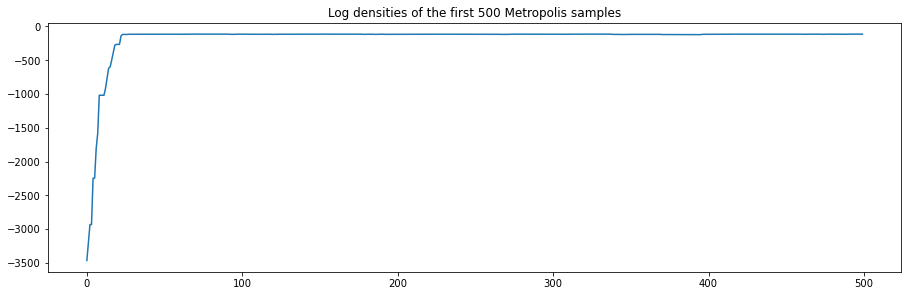

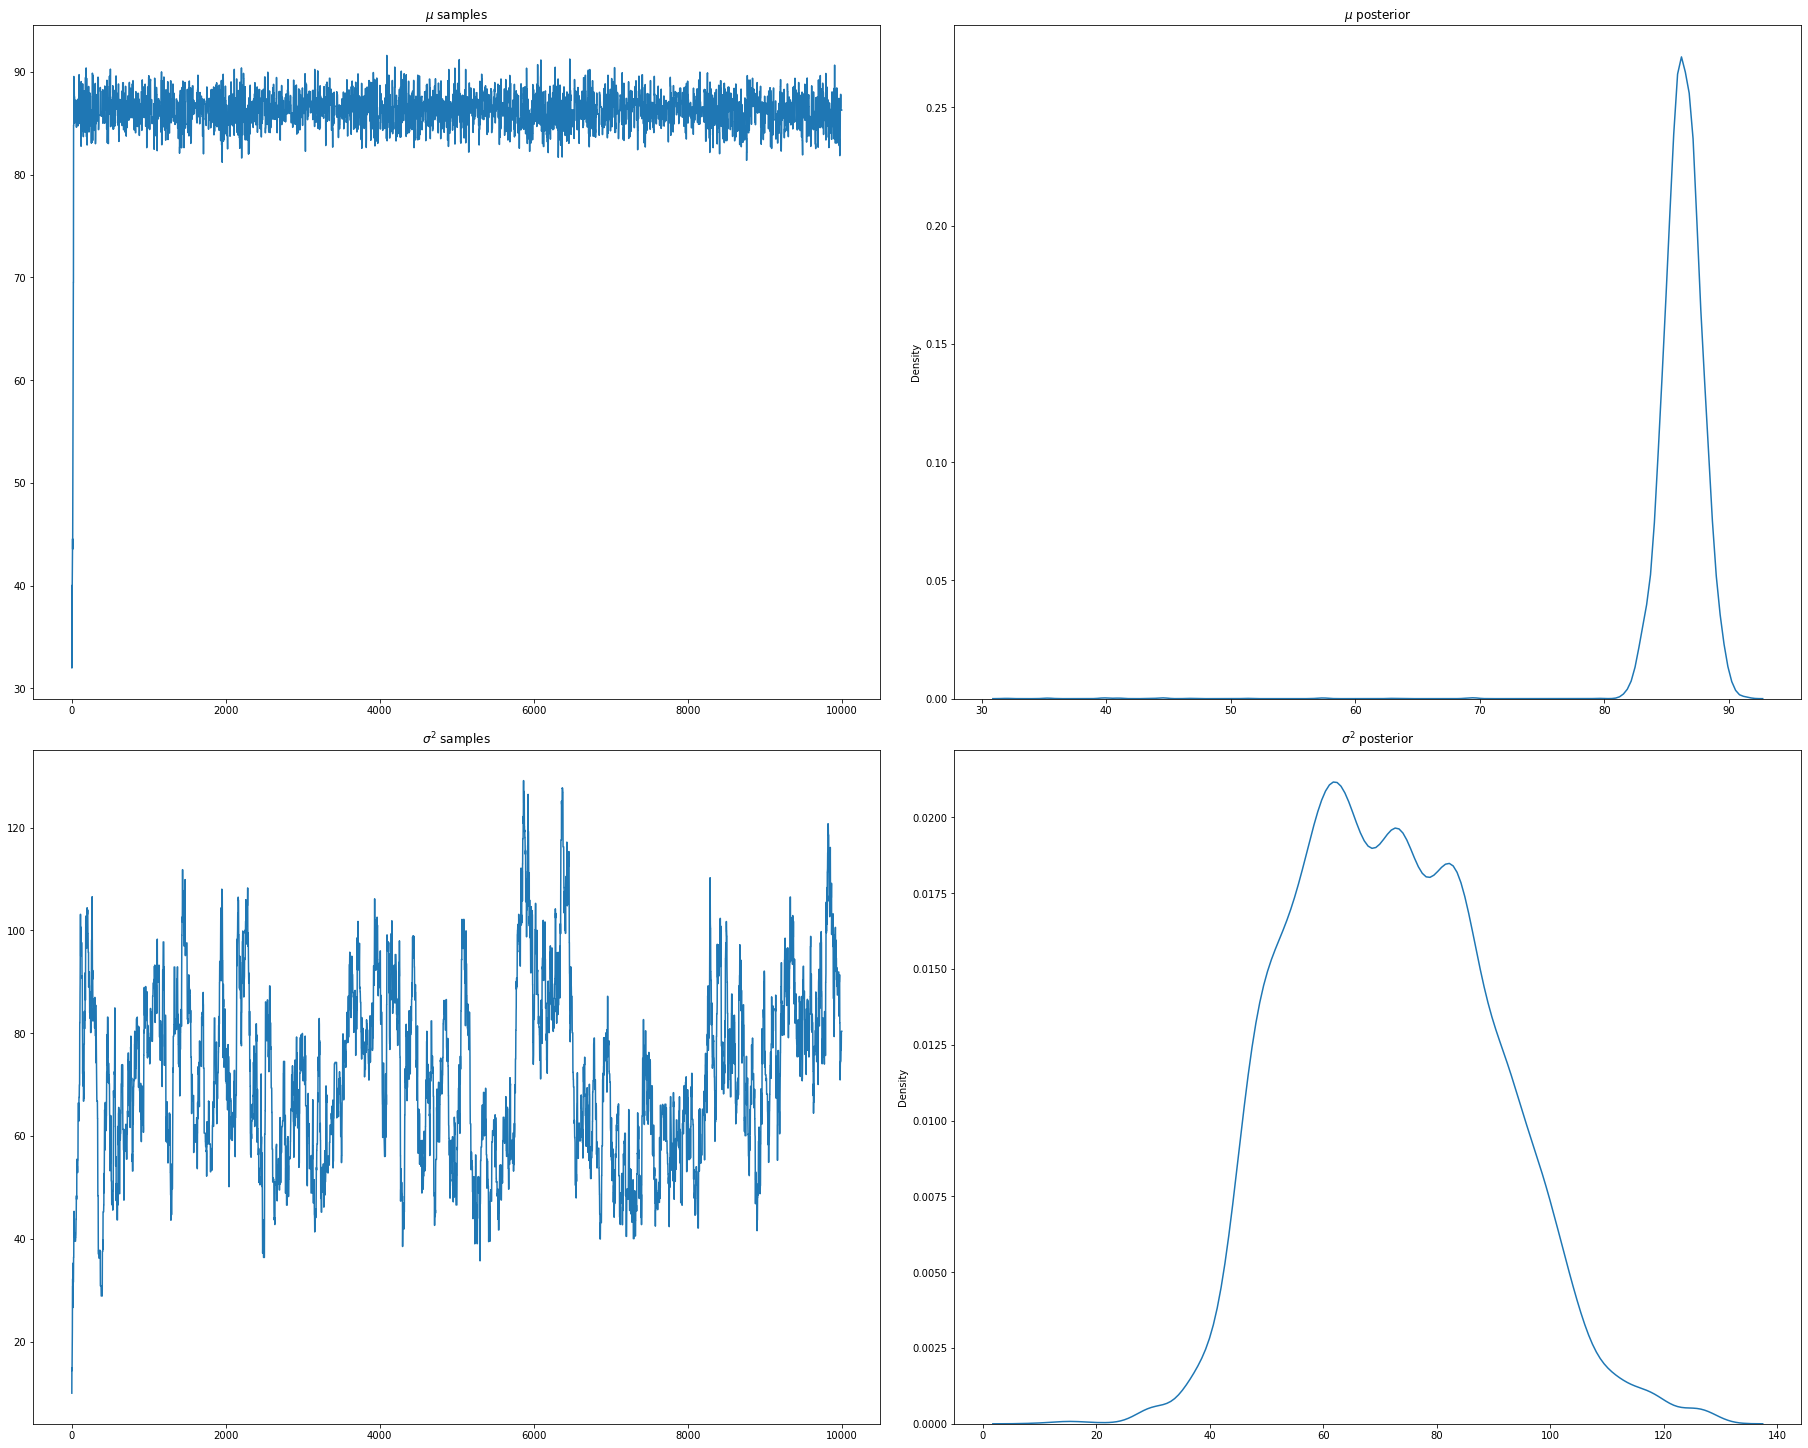

<Figure size 900x600 with 0 Axes>

Acceptance Rate: 0.34353435343534355


In [7]:
def metropolis(y0, s, n_samples):
    """Use the Metropolis algorithm to sample from posterior.
    Parameters:
     x0 ((2,) ndarray): The first entry is mu, the second entry is sigma^2.
     s (float): The standard deviation parameter for the proposal function.
     n_samples (int): The number of samples to generate.
   
   Returns:
     draws ((n_samples, 2) ndarray): The MCMC samples.
     logprobs ((n_samples,) ndarray): The log density of the samples.
     accept_rate (float): The proportion of accepted proposed samples."""
    
    #initalizes samples array
    samples = np.empty((n_samples, 2))
    #set first element
    samples[0] = y0
    #loop counter
    t = 0
    accept = 0
    while t < n_samples - 1:
        #get proposal sample
        prop = proposal(samples[t], s)
        #draw from uniform
        a = np.random.uniform(low=0, high=1)
        #check aacceptance probability and accept or reject accordingly
        if np.log(a) <= acceptance(prop, samples[t]):
            samples[t+1] = prop
            accept += 1
        else:
            samples[t+1] = samples[t]
        t+=1
    
    #return samples, logprobabilities, and acceptance rate. 
    return samples, np.array([propLogDensity(samples[i]) for i in range(500)]), accept/(n_samples-1)
        

def problem1():
    
    #     μ0 = np.random.normal(loc=m, scale=np.sqrt(s**2))
    #     σ20 = sig2prior.rvs(size=1)    
    
    y0 = np.array([40, 10])
    samples, logdensities, accept_rate = metropolis(y0, 20, int(1e4))
    
    
    #plot log densities
    fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(12.5, 4))
    axs.plot(logdensities)
    axs.set_title("Log densities of the first 500 Metropolis samples")
    plt.show()
    
    fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(25, 20))
    fig = plt.figure()
    fig.set_dpi(150)
    ax = axs[0, 0]
    #plot μ samples
    ax.plot(samples[:, 0])
    ax.set_title(r'$\mu$ samples')
    ax =axs[0, 1]
    sbn.kdeplot(samples[:, 0], ax=ax)
    ax.set_title(r'$\mu$ posterior')
    
    #plot σ2 samples
    ax = axs[1, 0]
    ax.plot(samples[:, 1])
    ax.set_title(r'$\sigma^2$ samples')
    ax = axs[1, 1]
    sbn.kdeplot(samples[:, 1], ax=ax)
    ax.set_title(r'$\sigma^2$ posterior')
    plt.show()
    
    print('Acceptance Rate:', accept_rate)
    
    return 

problem1()

## Problem 2

Write a function that accepts a spin configuration $\sigma$ for a lattice as a NumPy array.
Compute the energy $H(\sigma)$ of the spin configuration.
Be careful to not double count site pair interactions!

In [8]:
def random_lattice(n):
    """Construct a random spin configuration for an nxn lattice."""
    random_spin = np.zeros((n,n))
    for k in range(n):
        random_spin[k,:] = 2*np.random.binomial(1,.5, n) -1
    return random_spin

In [9]:
def lattice_energy(L):
    """Computer the energy of the spin configuration corresponding to the
    lattice L.
    Parameter:
     L (ndarray): A lattice that we want the spin configuration for.
    
    Returns:
     (float): The spinfiguration of the lattice.
    """
    
    #get shape of lattice
    m, n = L.shape
    #intialize energy
    energy = 0
    #now use np.roll() to get the associated energy of the spin configuration.
    for row in range(m):
        energy += -np.sum(L[row] * np.roll(L[row], 1))
        #energy += -np.sum(L[row] * np.roll(L[row], -1))
        
    for col in range(n):
        energy += -np.sum(L[:, col] * np.roll(L[:, col], 1))
        #energy += -np.sum(L[:, col] * np.roll(L[:, col],-1))

        
    return energy

## Problem 3

Write a function that accepts an integer $n$ and chooses a pair of indices $(i,j)$ where $0 \le i,j \le n-1$.
Each possible pair should have an equal probability $\frac{1}{n^2}$ of being chosen.

In [10]:
def flip_location(n):
    """Choose a random pair of indices 0 <= i,j <= n-1.
    Parameter:
     n (int): 1/(n^2) probability for each location
     
    Returns:
     (index1, index2) (tuple): the tuple pair of the chosen indices. 
    """
    #get array of possible indices
    indices = np.arange(0, n)
    #get all possible permutations of size 2, 
    #(add on the tuples with indices matching themselves)
    p = list(permutations(indices, 2))
    for i in range(n):
        p.append((i, i))   
        
    #p will be of size n**2 so we take a random choice of those indices and return
    #the corresponding tuple of indices
    choose = np.arange(0, n**2)
    choice = np.random.choice(choose)
    
    return p[choice]

## Problem 4

Write a function that accepts a spin configuration $\sigma$, its energy $H(\sigma)$, and integer indices $i$ and $j$.
Compute the energy of the new spin configuration $\sigma^*$, which is $\sigma$ but with the spin flipped at the $(i,j)$th entry of the corresponding lattice.
Do not explicitly construct the new lattice for $\sigma^*$.

In [11]:
def updated_energy(L, L_energy, i, j):
    """Compute the energy of the spin configuration that results
    when the (i,j)th spin of L is flipped.
    
    Parameters:
     L (ndarray): the spin configuration 
     L_energy (float): the energy of the spin configuration.
     i (int): the first index.
     j (int): the second index.
    Returns:
     (float): the energy of the new updated lattice
    """
    n, m = L.shape
    l = L[(i-1)%n, j]
    r = L[(i+1)%n, j]
    t = L[i, (j+1)%n]
    b = L[i, (j-1)%n]
    
    return L_energy + 2*L[i, j]*(l+r+t+b)

In [12]:
def test_updated_energy(L, L_energy, i, j):
    """Test the updated energy function above by explicitly construcing the new L_p
        and using the lattice_energy() functiona above. 
    """
    calculated = updated_energy(L, L_energy, i, j)
    Lp = L.copy()
    Lp[i, j] = -Lp[i, j]
    explicit = lattice_energy(Lp)
    
    assert np.allclose(calculated, explicit)
    
for _ in range(100):
    L = random_lattice(100)
    E = lattice_energy(L)
    i, j = flip_location(100)
    test_updated_energy(L, E, i, j)

## Problem 5

Write a function that accepts a float $\beta$ and spin configuration energies $H(\sigma)$ and $H(\sigma^*)$.
Calculate whether or not the new spin configuration $\sigma^*$ should be accepted (return `True` or `False`).

(Hint: np.random.binomial() might be useful function)

In [13]:
def accept(beta, energy_old, energy_new):
    """Accept or reject the new spin configuration.
    
    Parameters:
     beta (float): a quantity inversly proportional to the temperature.
     energy_old (float): the energy of the old lattice.
     energy_new (float): the energy of the updated lattice.
     
    Returns:
     (boolean): whether the new energy should be accepted or not
    """
    if energy_new < energy_old:
        return 1
    else:
        return np.random.binomial(1, np.exp(beta*(energy_old-energy_new)))

## Problem 6

Write a function that accepts a float $\beta>0$ and integers $n$, `n_samples`, and `burn_in`.
Initialize an $n\times n$ lattice for a spin configuration $\sigma$ using `random_lattice()`.
Use the Metropolis algorithm to (potentially) update the lattice `burn_in` times.
1. Use `flip_location()` to choose a site for possibly flipping the spin, thus defining a potential new configuration $\sigma^*$.
2. Use `updated_energy()` to calculate the energy $H(\sigma^*)$ of the proposed configuration.
3. Use `accept()` to accept or reject the proposed configuration. If it is accepted, set $\sigma = \sigma^*$ by flipping the spin at the indicated site.
4. Track $-\beta H(\sigma)$ at each iteration (independent of acceptance).

After the burn-in period, continue the iteration `n_samples` times, also recording every $100$th sample (to prevent memory failure).
Return the samples, the sequence of weighted energies $-\beta H(\sigma)$, and the acceptance rate.

Test your sampler on a $100 \times 100$ grid with $200000$ total iterations, with `n_samples` large enough so that you will keep $50$ samples, for $\beta = 0.2, 0.4, 1$.
Plot the proportional log probabilities, as well as a late sample from each test.


acceptance rate for β = 0.2: 0.691
acceptance rate for β = 0.4: 0.3498
acceptance rate for β = 1: 0.072


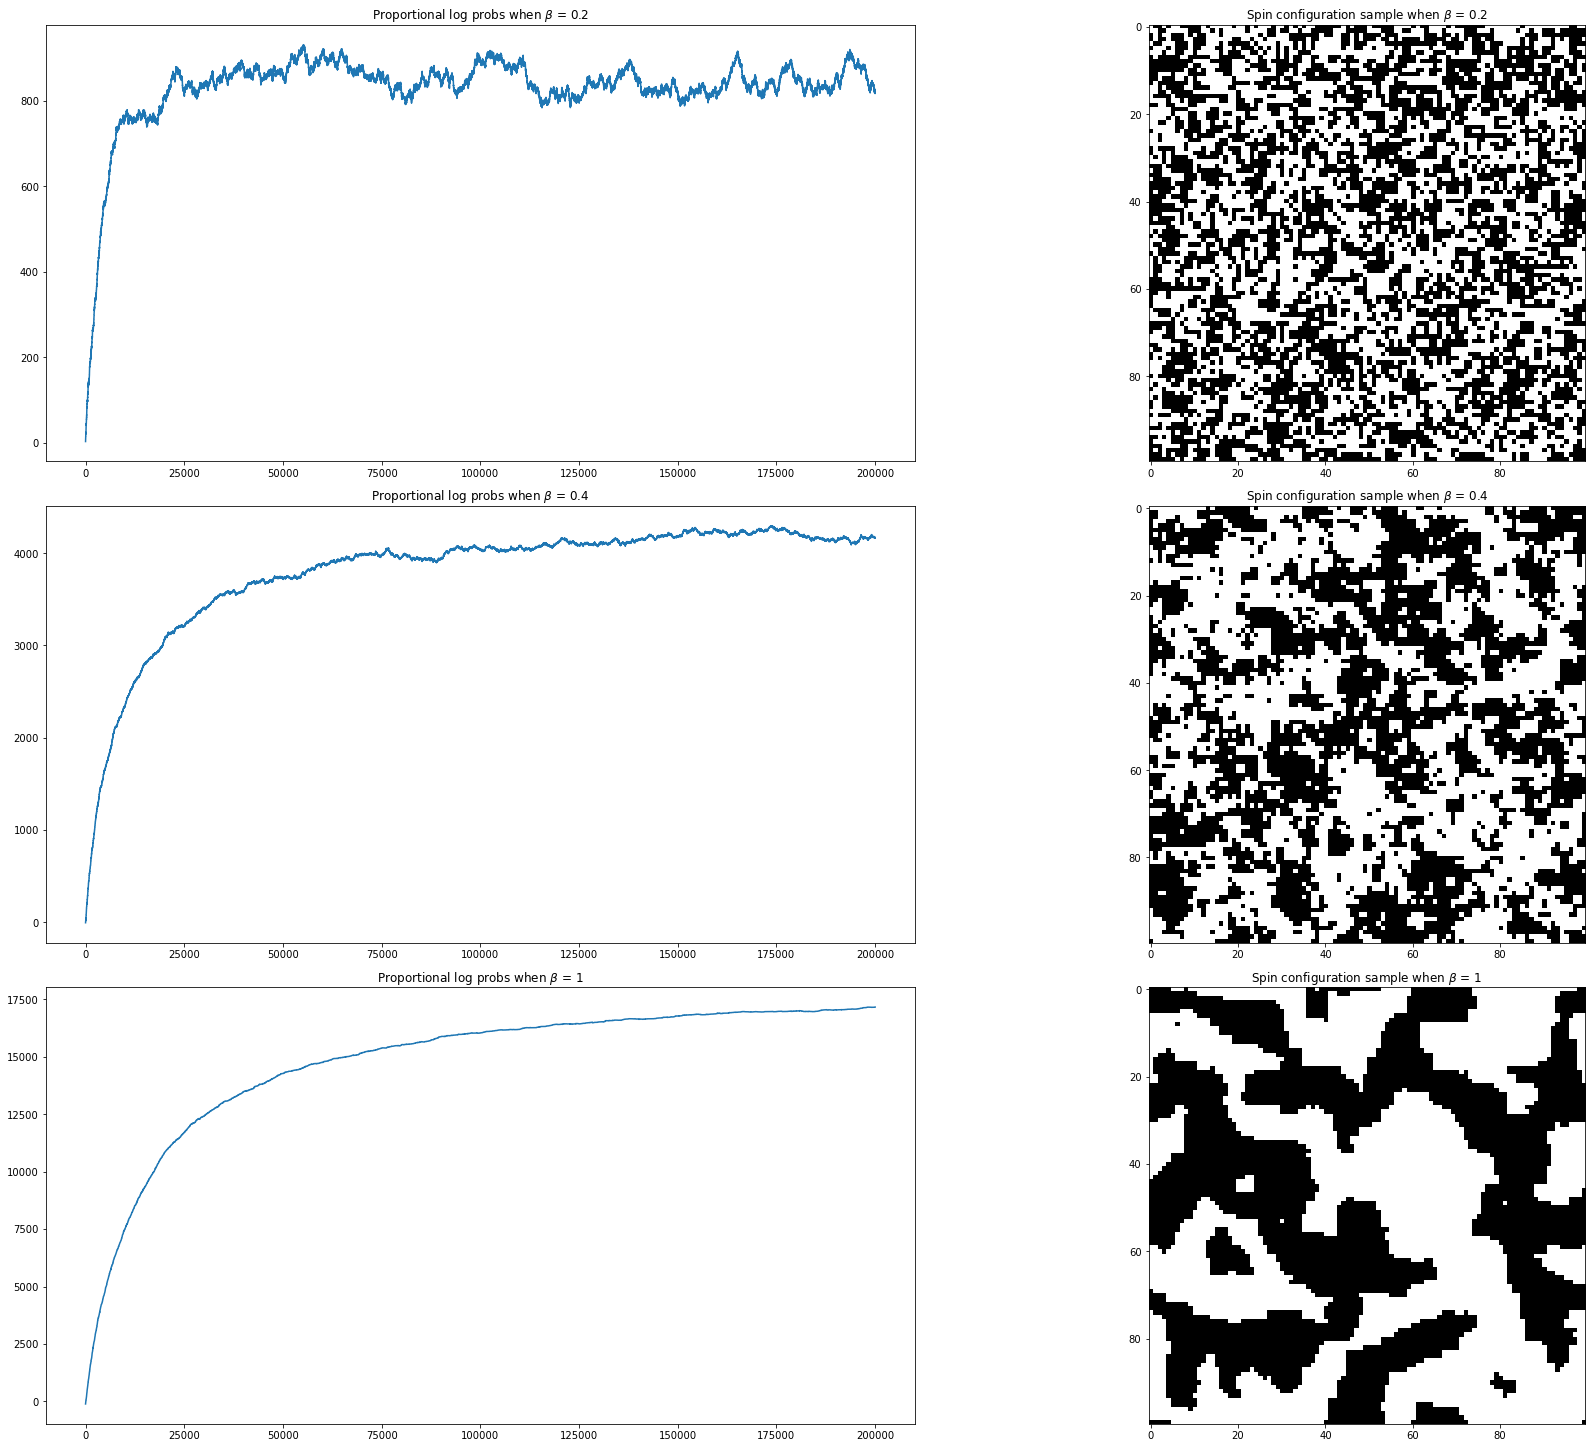

In [21]:
def ising_metropolis(beta, n=100, n_samples=5000, burn_in=195000):
    """Use the Metropolis algorithm to choose new spin configurations.

    Parameters:
        beta (float > 0): Constant inversely proportional to the temperature.
        N (int > 0): The size of the lattice.
        n_samples (int): The number of samples to generate.
        burnin (int): The number of iterations to burn before sampling.

    Returns:
        ((n_samples//100, n,n) ndarray): The sampled spin configurations.
        (n_samples) ndarray: The weighted energies of each configuration.
        (float): The proportion of proposed samples that were accepted.
    """
    
    #intialize arrays and values to return
    samples = np.empty((n_samples//100, n, n))
    weighted_energies = np.empty(burn_in + n_samples)
    accepted = 0
    
    #get intial lattice and lattice energy
    L0 = random_lattice(n)
    E0 = lattice_energy(L0)
    
    t = 0
    while t < n_samples + burn_in:
        #get flip location
        i, j = flip_location(n)
        
        #get updated lattice energy
        E1 = updated_energy(L0, E0, i, j)
        
        #accpet or reject sample
        if accept(beta, E0, E1):
            L0[i, j] =-L0[i, j]
            E0 = E1
            if t >= burn_in:
                accepted += 1
        #if we are passed the burn in, record the smaple        
        if t >= burn_in:
            if (t-burn_in)%100 == 0:
                samples[(t-burn_in)//100] = L0.copy()
        
        #get weighted energies
        weighted_energies[t] = -beta*E0
        t+=1
        
    return samples, weighted_energies, accepted/(n_samples)


β_vals = [0.2, 0.4, 1]
fig, axs = plt.subplots(3, 2, constrained_layout=True, figsize=(25, 20))

for i, β in enumerate(β_vals):
    samples, weighted_energies, rate = ising_metropolis(β)
    print('acceptance rate for β = ' + str(β) + ':', rate)
    
    ax = axs[i, 0]
    ax.plot(weighted_energies)
    ax.set_title(r'Proportional log probs when $\beta$ = ' + str(β))
    
    ax = axs[i, 1]
    ax.imshow(samples[-1], cmap='gray')
    ax.set_title(r'Spin configuration sample when $\beta$ = ' + str(β))
    
plt.show()